In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
data_path= "../data/METR-LA.h5"
df = pd.read_hdf(data_path)
print(df.head(6))

                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:25:00  57.333333  69.000000  67.666667  61.666667  67.333333   

                        717445     773062     767620     737529     717816  \
2012-03-01 00:00:00  68.750000  65.125000  67.125000  59.625000  62.750000   
2012-03-01 00:05:00  68.111111  65.000000  65.000000  57.444444  63.333333   
2012-03-01 00:10:00  66.250000  64.500000  64.250000  63.875000  65.375000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000

In [26]:
data= (df.values-df.values.mean())/df.values.std() 


In [27]:
seq_len = 12
pred_len = 3

In [28]:
def create_seq (data, seq_len, pred_len):
    X,y = [],[]
    for t in range (seq_len, len(data)-pred_len):
        X.append(data[t-seq_len:t])
        y.append (data[t:t+pred_len])
    return np.array(X), np.array(y)

In [29]:
X, y = create_seq (data, seq_len, pred_len)

print ("X shape:", X.shape)
print ("y sahpe", y.shape)

X shape: (34257, 12, 207)
y sahpe (34257, 3, 207)


In [30]:
import torch

X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)


In [31]:
from torch.utils.data import Dataset 

class Traffic_Dataset (Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__ (self):
        return self.X.shape[0]
    def __getitem__ (self, idx):
        return self.X[idx], self.y[idx]


In [32]:
from torch.utils.data import DataLoader 
dataset = Traffic_Dataset (X_torch, y_torch)

batch_size = 32
loader = DataLoader (dataset, batch_size= batch_size, shuffle = True)

print ("Toatal samples", len(dataset))


Toatal samples 34257


In [33]:
for xb, yb in loader:
    print("Batch X:", xb.shape)
    print("Batch y:", yb.shape)
    break

Batch X: torch.Size([32, 12, 207])
Batch y: torch.Size([32, 3, 207])


In [34]:
import torch.nn as nn
class DummyModel(nn.Module):
    def __init__(self, seq_len, num_nodes, pred_len):
        super().__init__()
        self.fc = nn.Linear(seq_len * num_nodes, pred_len * num_nodes)

    def forward(self, x):
        # x shape: (batch, seq_len, num_nodes)
        b, t, n = x.shape

        x = x.view(b, t * n)          
        out = self.fc(x)             
        out = out.view(b, pred_len, n)  # reshape back

        return out

In [35]:
num_nodes = 207

model = DummyModel(
    seq_len=seq_len,
    num_nodes=num_nodes,
    pred_len=pred_len
)

In [36]:
for xb, yb in loader:
    y_pred = model(xb)

    print("Input batch shape:", xb.shape)
    print("Predicted output shape:", y_pred.shape)
    print("Target shape:", yb.shape)
    break

Input batch shape: torch.Size([32, 12, 207])
Predicted output shape: torch.Size([32, 3, 207])
Target shape: torch.Size([32, 3, 207])


In [37]:
loss_fn = torch.nn.L1Loss()          # MAE loss (regression)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0001
)

In [38]:
epochs = 5

for epoch in range(epochs):
    epoch_loss = 0.0

    for xb, yb in loader:
        optimizer.zero_grad()        # clear old gradients
        y_pred = model(xb)           # forward pass
        loss = loss_fn(y_pred, yb)   # compute loss
        loss.backward()              # compute gradients
        optimizer.step()             # update weights

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.2732
Epoch 2/5, Loss: 0.2174
Epoch 3/5, Loss: 0.2035
Epoch 4/5, Loss: 0.1951
Epoch 5/5, Loss: 0.1890


In [39]:
model.eval()   

with torch.no_grad():
    for xb, yb in loader:
        y_pred = model(xb)
        break

In [40]:
sensor_id = 69

true_values = yb[16, :, sensor_id].numpy()
pred_values = y_pred[16, :, sensor_id].numpy()

print("True:", true_values)
print("Pred:", pred_values)

True: [0.6369727  0.53209364 0.72128725]
Pred: [0.78639317 0.6258995  0.688094  ]


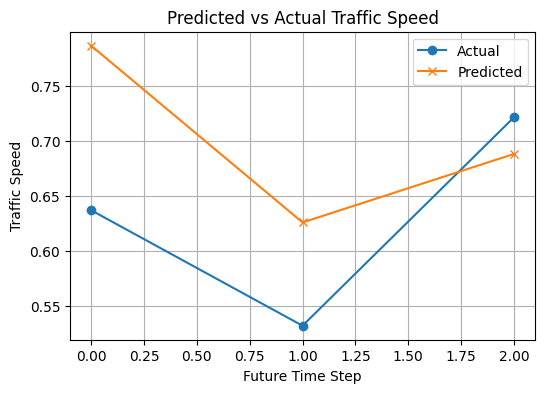

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(true_values, label="Actual", marker='o')
plt.plot(pred_values, label="Predicted", marker='x')
plt.xlabel("Future Time Step")
plt.ylabel("Traffic Speed")
plt.title("Predicted vs Actual Traffic Speed")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
torch.save(model.state_dict(), "../models/temporal_baseline.pth")

In [43]:
import pickle
import numpy as np

adj_path = "../data/adj_METR-LA.pkl"

with open(adj_path, "rb") as f:
    adj_data = pickle.load(f,encoding="latin1")
type (adj_data)
#print(adj_data)

list

In [44]:
adj_matrix = adj_data[2]

print (type(adj_matrix))

<class 'numpy.ndarray'>


In [45]:
A = torch.tensor(adj_matrix, dtype= torch.float32)
print(A.shape)

torch.Size([207, 207])


In [46]:
I = torch.eye(A.size(0))
A_hat = A + I

# Degree matrix
D = torch.diag(torch.sum(A_hat, dim=1))

# D^{-1/2}
D_inv_sqrt = torch.pow(D, -0.5)
D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0

# Normalized adjacency
A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt

print(A_norm.shape)

torch.Size([207, 207])


In [47]:
torch.save(A_norm, "../data/adj_norm_METR_LA.pt")